In [1]:
#____________________________________________________________________________________
#______________     PYTHON CODE ON ID HELIUM DBD   (7-11-2017)  _____________________
#______________                 SAURAV GAUTAM         _______________________________
#____________________________________________________________________________________
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.sparse.linalg as la
import scipy.sparse as sparse
import time as tm

In [2]:
####POISSON MATRIX USED TO SOLVE THE POISSON'S EQUATION IMPLICTLY====
def SparseLaplacianOperator(nx,k1=-1,k2=0,k3=1):
    d1=np.zeros((nx),float)
    d2=np.ones((nx),float)
    d3=np.zeros((nx),float)
    d1[:-2]=1
    d2[1:-1]=-2
    d3[2:]=1
    return (sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc() )

In [3]:
####IMPORTING THE TRANSPORT AND REACTION COEFFICIENTS FROM TEXT FILE======================================
def readBoltzmannParameters1(npoints,oupfile='table.txt',ns=4,nR=5):
    mobility=np.zeros((ns,npoints),float)
    diffusion=np.zeros((ns,npoints),float)
    source=np.zeros((nR,npoints),float)
    file=open(oupfile)
    line=file.readline()
    for data in np.arange(npoints):
       line=file.readline()
       lineSplit=line.split()
       mobility[0,data]=float(lineSplit[0]);mobility[1,data]=float(lineSplit[1]);mobility[2,data]=float(lineSplit[2])
       diffusion[0,data]=float(lineSplit[3]);diffusion[1,data]=float(lineSplit[4]);diffusion[2,data]=float(lineSplit[5])
       diffusion[3,data]=float(lineSplit[6])
       source[0,data]=float(lineSplit[7]);source[1,data]=float(lineSplit[8]);source[2,data]=float(lineSplit[9])
       source[3,data]=float(lineSplit[10]);source[4,data]=float(lineSplit[11])
    return(mobility,diffusion,source)

In [4]:
#SPARSE TRIDIAGONAL MATRIX USED TO SOLVE THE DIFFUSION EQUATION IMPLICTLY====================================
def SparseDiffusionOperator(numberdensity,dif,dx,dt,k1=-1,k2=0,k3=1):
    nx=dif.size
    d1=np.zeros((nx),float)
    d2=np.ones((nx),float)
    d3=np.zeros((nx),float)
    d1[:-2]=(dt/(4*dx*dx))*(dif[2:]-dif[:-2]-4*dif[1:-1])
    d2[1:-1]=(1+2*dt*dif[1:-1]/(dx**2))
    d3[2:]=(dt/(4*dx*dx))*(-dif[2:]+dif[:-2]-4*dif[1:-1])
    return (la.spsolve((sparse.dia_matrix(([d1,d2,d3],[k1,k2,k3]),shape=(nx,nx)).tocsc()),numberdensity))

In [5]:
#INTERPOLATION FORMULA ======================================================================================
def Interpolation(efield,inputdata):
    indlocate=abs(efield[:]).astype(int)
    return(inputdata[:,indlocate]+(inputdata[:,indlocate+1]-inputdata[:,indlocate])*(abs(efield)-indlocate))

In [6]:
#ADVECTION SOLVING MATRIX====================================================================================
def AdvectionAlgorithm(dx,dt,velocity,density):
    flux=(0.5*(velocity[1:]*density[1:]+velocity[:-1]*density[:-1])-0.5*0.5*abs(velocity[1:]+velocity[:-1])*(density[1:]-density[:-1]))*dt
    density[1:-1]+= -(flux[1:]-flux[:-1])/dx
    return density[1:-1]

In [7]:
start = tm.time()

parameterSize=996 #NUMBER OF ROWS IN THE INPUT TEXT FILE
(mobilityInput,diffusionInput,sourceInput) = readBoltzmannParameters1(parameterSize,'table.txt')# reading from the input file
mobilityInput[1]=mobilityInput[1]/0.12*1.6   #correction
diffusionInput[1]=diffusionInput[1]/0.12*1.6 #correction
mobilityInput[2]=mobilityInput[2]/0.12*1.6   #correction
diffusionInput[2]=diffusionInput[2]/0.12*1.6 #correction

In [8]:
#*** Parameters for the of plasma reactor====================================================================
width=2.0                     #space between two dielectric in mm
ngrid0=300                    #Number of grid points (between two dielectric)
wd1=0.8                       #width of first dielectric in mm
wd2=0.8                       #width of second dielectric in mm
dx=width*10**(-3)/(ngrid0+1.0)#Grid size in meter
nwd1=int(wd1*10**(-3)/dx)     #number of grid points in first dielectric
nwd2=int(wd2*10**(-3)/dx)     #Number of grid points in second dielectric
wd1=nwd1*dx                   #Making wd1 as exact multiple of dx
wd2=nwd2*dx                   #making wd2 as exact multiple of dx
inelec=width*10**(-3)+wd1+wd2 #total interelectrode separation
ngrid=int(ngrid0+2+nwd1+nwd2) #total number of grid points(2 dielectrics +gas medium + all edge points)
#--------------------------------------------------------------------------------------------------------------
volt=5000.0                   #Interelectrode voltage (peak not RMS)
gasdens=2.504e25              #number density of gas at NTP (unit: m^-3)
dt=1.0e-10                    #small time interval
frequencySource =  41000       #in Hz
ee=1.6*10**(-19)              #electronic charge
e0=8.54187817*10**(-12)       #epsilon
townsendunit=1.0/((gasdens)*(10)**(-21))#townsend factor
Kboltz=1.380*10e-23           #Boltzmann constant
desorption=1*10.                #desorption coefficient
recombination=1e-10           #surface recombination coefficient
gamma=0.01                    #secondary electron emission coefficient

In [9]:
#*** Initialization
#-----------------------------------------------------------------------------------------------------
ns=4                                    #total number of species
nr=5                                    #total number of chemical reactions
ndensity=np.zeros((ns,ngrid0+2),float)  #number density of each species
ncharge=np.array([-1,1,1,0])            #corresponding charge of the each species
gMat=np.array([0,1,1,0])                #gamma matrix (boolean what produces secondary electrons)
dMat=np.array([1,0,0,0])                #boolean, which species undergoes desportion from surface
netcharge=np.zeros(ngrid,float)         #net charge at each grid points
potentl=np.zeros(ngrid,float)           #potential at each grid points
efield=np.zeros(ngrid0+2,float)         #electric field at each grid points
efieldP=np.zeros(ngrid0+2,float)        #electric field at each grid points

mobilityG=np.zeros((ns,ngrid0+2),float) #mobility at each grid points
diffusionG=np.zeros((ns,ngrid0+2),float)#diffusion coefficient at grid points
sourceG=np.zeros((nr,ngrid0+2),float)   #source at each grid points
fluxLR=np.zeros((ns,2),float)           #particle flux towards left and right boundries
react=np.zeros((4,ngrid0+2),float)      #reaction 
sigmaLR=np.zeros((ns,2),float)          #surface charge density
tempSigma=np.zeros((ns,2),float)        #temporary surface charge density
eEjection=np.zeros((2),float)           #electrons leaving the boundary

poissonSparseMatrix=SparseLaplacianOperator(ngrid)  #poisson equation solving matrix
numberOfSteps = 500000                              #total number of time steps
stepping=100                                        #time steps to skip before saving the data

storedensity=np.zeros((int(numberOfSteps/stepping),ns,ngrid0+2),float)          #number density    
storenetcharge=np.zeros((int(numberOfSteps/stepping),ngrid0+2+nwd1+nwd2),float) #net charge
storeefield=np.zeros((int(numberOfSteps/stepping),ngrid0+2),float)              #elecritc field
storepotentl=np.zeros((int(numberOfSteps/stepping),ngrid0+2+nwd1+nwd2),float)   #potential
#storeReact=np.zeros((int(numberOfSteps/stepping),ns,ngrid0+2),float)           #production rate
#storeR=np.zeros((int(numberOfSteps/stepping),nr,ngrid0+2),float)               #reaction rate
storeCurrent=np.zeros((int(numberOfSteps/stepping)),float)                      #current
ndensity=1000*np.random.rand(ns,ngrid0+2) #initializing the number densities with random value       

In [10]:
time=0.0
#=======================time Loop======================================================================
for tymeStep in range(1,numberOfSteps):
    time=time+dt

    
    #                           *** POISSON'S EQUATION ***
    #-------------------------------------------------------------------------------------------
    netcharge[nwd1:nwd1+2+ngrid0]=ee*np.dot(ncharge,ndensity)   #calculating net charge
    netcharge[nwd1+1:nwd1+1+ngrid0]=0.                          #quasi neutrality condition
    leftPot=1.0*volt*np.sin(2*np.pi*time*frequencySource)       #applied voltage (left)
    rightpot=0.0*volt*np.sin(2*np.pi*time*frequencySource)      #applied voltage (right)
    chrgg=-(netcharge/e0)*dx*dx                                 #RHS matrix. <Read documentation>
    chrgg[0]=leftPot                                            #left boundary condition
    chrgg[-1]=rightpot                                          #right boundary condition
    potentl=la.spsolve(poissonSparseMatrix,chrgg)               #solving system of Matrix equations
    
    #**calculate electric field as negative gradient of potential (Expressed in Townsend Unit)
    efield[:]=-townsendunit*(potentl[nwd1+1:nwd1+3+ngrid0]-potentl[nwd1-1:nwd1+1+ngrid0])/(2.0*dx)
    efield[0]=-townsendunit*(-(11.0/6)*potentl[nwd1]+3.0*potentl[nwd1+1]-(3.0/2)*potentl[nwd1+2]+(1.0/3)*potentl[nwd1+3])/dx
    efield[-1]=-townsendunit*(potentl[nwd1+1+ngrid0]-potentl[nwd1+ngrid0])/dx
    
    if any(abs(efield[:])>995):#Stop the program if E>995 Townsends.
         sys.exit()
    
    
    #                      *** TRANSPORT AND REACTION COEFFICIENTS ***
    #----------------------------------------------------------------------------------------------
    mobilityG=np.transpose(ncharge*np.transpose(Interpolation(efield,mobilityInput))) #mobility
    diffusionG=Interpolation(efield,diffusionInput)                                   #diffusion
    sourceG=Interpolation(efield,sourceInput)                                         #reaction rate
    efield[:]=efield[:]/townsendunit #converting Efield back to SI(V/m) unit from Townsend's unit

    
    #                               *** SOURCE TERM ***
    #-----------------------------------------------------------------------------------------------
    R1=sourceG[0]*(ndensity[0]+1*10000)*gasdens*dt        #source of reaction-1 <read documentation>
    R2=1*sourceG[1]*(ndensity[0]+1*10000)*ndensity[3]*dt  #source of reaction-2 <read documentation>
    R3=1*gasdens*gasdens*sourceG[2]*ndensity[1]*dt        #source of reaction-3 <read documentation>
    R4=1*sourceG[3]*(ndensity[0]+1*10000)*ndensity[2]*dt  #source of reaction-4 <read documentation>
    R5=1*(ndensity[0]+1*10000)*gasdens*sourceG[4]*dt      #source of reaction-5 <read documentation>
    
    react[0]=(R1+R2-R4)                 #production of particle [0]
    react[1]=(R1+R2-R3)                 #production of particle [1]
    react[2]=(R3-R4)                    #production of particle [2]
    react[3]=(-R2+R5)                   #production of particle [3]
    ndensity[:,1:-1]+= react[:,1:-1]    #adding newly produced particles to the gas
    
    
    #                            *** CURRENT CALCULATION ***
    #------------------------------------------------------------------------------------------------
    current=ee*np.sum((efield[2:-2]*mobilityG[1,2:-2]*ndensity[1,2:-2]
                                                                  +  1*efield[2:-2]*mobilityG[2,2:-2]*ndensity[2,2:-2]+   
                                                                  efield[2:-2]*mobilityG[0,2:-2]*ndensity[0,2:-2]-  
                                                                  diffusionG[2,2:-2]*(ndensity[2,3:-1]  -ndensity[2,1:-3])/(2*dx)
                                                                  -diffusionG[1,2:-2]*(ndensity[1,3:-1]-ndensity[1,1:-3])/(2*dx)
                                                                  +diffusionG[0,2:-2]*(ndensity[0,3:-1]-ndensity[0,1:-3])/(2*dx))*dx)

    
    #                                    *** DIFFUSION ***
    #-------------------------------------------------------------------------------------------------------
    temporaryCopy=ndensity.copy()                                                 #making a copy of nDensity 
    temporaryCopy[:,0]=temporaryCopy[:,1].copy()                                  #mirror boundary (left)
    temporaryCopy[:,-1]=temporaryCopy[:,-2].copy()                                #mirror boundary (right)
    temporaryCopy[0]=SparseDiffusionOperator(temporaryCopy[0],diffusionG[0],dx,dt)#solving Implictly for[0]
    temporaryCopy[1]=SparseDiffusionOperator(temporaryCopy[1],diffusionG[1],dx,dt)#solving Implictly for[1]
    temporaryCopy[2]=SparseDiffusionOperator(temporaryCopy[2],diffusionG[2],dx,dt)#solving Implictly for[2]
    temporaryCopy[3]=SparseDiffusionOperator(temporaryCopy[3],diffusionG[3],dx,dt)#solving Implictly for[3]
    
    
    #                                   *** ADVECTION ***
    #-------------------------------------------------------------------------------------------------------
    temporaryCopy[:-1,0]=fluxLR[:-1,0]*dt/dx              #left boundary condition
    temporaryCopy[:-1,-1]=fluxLR[:-1,1]*dt/dx             #right boundary condition
        
    temporaryCopy[0,1:-1]=AdvectionAlgorithm(dx,dt,mobilityG[0]*efield,temporaryCopy[0]) #solving for [0]
    temporaryCopy[1,1:-1]=AdvectionAlgorithm(dx,dt,mobilityG[1]*efield,temporaryCopy[1]) #solving for [1]
    temporaryCopy[2,1:-1]=AdvectionAlgorithm(dx,dt,mobilityG[2]*efield,temporaryCopy[2]) #solving for [2]
    ndensity[:,1:-1]=temporaryCopy[:,1:-1].copy()#copying back
    
    
    #                           ***BOUNDARY *** (charge accumulation at surface of dielectric)
    #--------------------------------------------------------------------------------------------------------
    recoMat=recombination*np.array([[  sigmaLR[0,0]*sigmaLR[1,0]+sigmaLR[0,0]*sigmaLR[2,0],sigmaLR[0,0]*sigmaLR[1,0],sigmaLR[0,0]*sigmaLR[2,0],0.],
                      [sigmaLR[0,1]*sigmaLR[1,1]+sigmaLR[0,1]*sigmaLR[2,1],sigmaLR[0,1]*sigmaLR[1,1],sigmaLR[0,1]*sigmaLR[2,1],0.]])
                      #recoMat is the MATRIX used for calculating electron-ion recombination on dielectric surfaces
    velocity=mobilityG*efield                                                             #velocity of particles
    fluxLR[:,0]=-(ndensity[:,1]*velocity[:,1]+gamma*gMat*ndensity[:,1]*velocity[:,1])     #flux at left dielectric
    fluxLR[:,1]=(ndensity[:,-2]*velocity[:,-2]+gamma*gMat*ndensity[:,-2]*velocity[:,-2])  #flux at right dielectric
    fluxLR[fluxLR<0]=0.                                                                   #non negative condition 
    sigmaLR[:,0]+=dt*(fluxLR[:,0]-desorption*dMat*sigmaLR[:,0]-recoMat[0])                #surface charge density (left dielectric)
    sigmaLR[:,1]+=dt*(fluxLR[:,1]-desorption*dMat*sigmaLR[:,1]-recoMat[1])                #surface charge density(right dielectric)
    #------
    secondary1=-gamma*(ndensity[1,1]*velocity[1,1]+ndensity[2,1]*velocity[2,1])           #secondary electron emission on left dielectric
    secondary2=gamma*(ndensity[1,-2]*velocity[1,-2]+ndensity[2,-2]*velocity[2,-2])        #secondary electron emission on right dielectric
    if secondary1<0:secondary1=0                                                          #non-negative condition
    if secondary2<0:secondary2=0                                                          #non-negative condition
    ndensity[0,1:5]=(dt*(desorption*sigmaLR[0,0]/4+secondary1/4)+ndensity[0,1:5]*dx)/dx   #electron added near left boundary (desorption+secondary emission)
    ndensity[0,-6:-2]=(dt*(desorption*sigmaLR[0,1]/4+secondary2/4)+ndensity[0,-6:-2]*dx)/dx#electron added near right boundary (desorption+secondary emission)
    #------             
    ndensity[:-1,0]=sigmaLR[:-1,0]/dx    #volume charge density approximation due to charge accumulation on left dielectric            
    ndensity[:-1,-1]=sigmaLR[:-1,1]/dx   #volume charge density approximation due to charge accumulation on left dielectric
    ndensity[:,ndensity[0]<0]=0.         #non-negative number of particles
    
    
    #                   *** DATA STORAGE ***
    #---------------------------------------------------------
    if (tymeStep%stepping==0):
        #print(mobilityG[0,10],mobilityG[1,10],mobilityG[2,10])
        storedensity[int(tymeStep/stepping),:,:]=ndensity[:,:]
        storenetcharge[int(tymeStep/stepping)]=netcharge
        storeefield[int(tymeStep/stepping)]=efield
        storepotentl[int(tymeStep/stepping)]=potentl
        storeCurrent[int(tymeStep/stepping)]=current
        
done = tm.time()
elapsed = done - start
print(elapsed)

1991.2653665542603


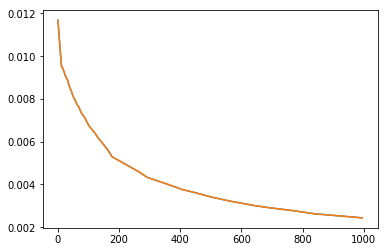

In [11]:

plt.plot(mobilityInput[2])
plt.plot(mobilityInput[1]/(2)**(1/2))

In [1]:
500000/1991

251.13008538422903

In [2]:
90*1991/5

35838.0

In [3]:
35838/3600

9.955

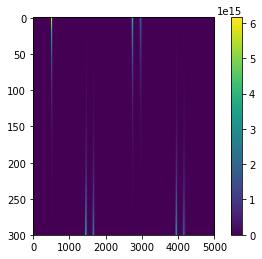

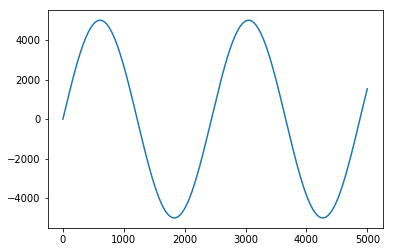

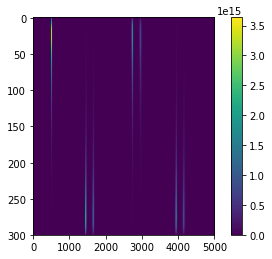

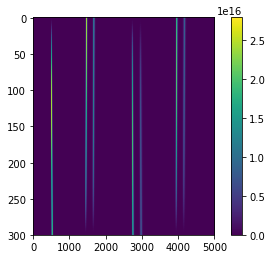

In [12]:
plt.imshow((np.transpose((((storedensity[:,0,1:-1]))))),aspect=20)
plt.colorbar()
plt.show()
plt.plot(storepotentl[:,0])
plt.show()
plt.imshow((np.transpose((storedensity[:,1,1:-1]))),aspect=20)
plt.colorbar()
plt.show()
plt.imshow((np.transpose(storedensity[:,2,1:-1])),aspect=20)
plt.colorbar()
plt.show()

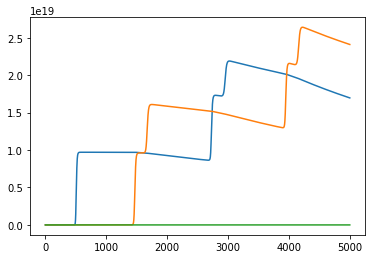

In [13]:
plt.plot(storedensity[:,0,0])
plt.plot(storedensity[:,2,0])
plt.plot(storedensity[:,0,10        ])

In [14]:
print(sum(ndensity[0]))
print(sum(ndensity[2]))

4.100366421763765e+19
4.110881915888603e+19


<Figure size 576x288 with 0 Axes>

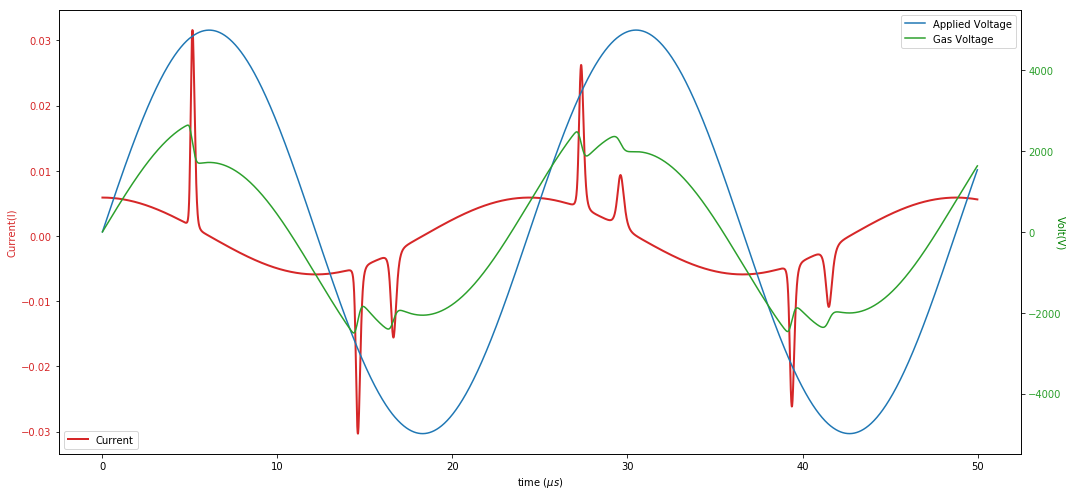

In [15]:
nns=(int(numberOfSteps/stepping))
plt.figure(figsize=(8,4))
#plt.plot(np.arange(10000)/100,storepotentl[:,1],label="Applied Voltage")
#plt.xlabel('Time ($\mu s$)')
#plt.ylabel('Voltage (V)')
#plt.plot(np.arange(10000)/100,storepotentl[:,nwd1+1]-storepotentl[:,nwd1+2+ngrid0],label="Gas Voltage")
#plt.plot(np.arange(nns)/100,storeCurrent[0:nns]*storepotentl[:,0]/(storepotentl[:,nwd1+1]-storepotentl[:,nwd1+2+ngrid0]))
#plt.axis([0,100,-6200,9200])
#plt.legend()
#plt.savefig('Voltage Graph.jpg', format='jpg', dpi=1000)

k1=3.7
k2=1.
k3=3.7
d1=0.8e-3
d2=2.0e-3
d3=0.8e-3
Eo=8.85e-12
A1=A2=A3=(22./7)*(2e-2)**2
C1=k1*Eo*A1/d1
C2=k2*Eo*A2/d2
C3=k3*Eo*A3/d3
Capacitance=1/(1/C1+1/C2+1/C3)

CurrentReactor=storeCurrent[0:nns]
CurrentReactor=(A1/(width*1e-3))*CurrentReactor

#displacement current
timmer=np.arange(nns)/nns*dt*numberOfSteps
IDis=Capacitance*2*np.pi*volt*frequencySource*np.cos(2*np.pi*frequencySource*timmer)

#plt.plot(IDis)
TotalCurrent=IDis+1*CurrentReactor


fig, ax1 = plt.subplots(figsize=(15,7))
color = 'tab:red'
ax1.set_xlabel('time ($\mu s$)')
ax1.set_ylabel('Current(I)', color=color)
ax1.plot(np.arange(nns)/100,TotalCurrent,color=color,linewidth=2.0,label="Current")
ax1.tick_params(axis='y', labelcolor=color)
#ax1.axis([38,100,-0.0198,0.0198])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1.legend(loc=3) 
color = 'tab:blue'
ax2.set_ylabel('Volt(V)', color='green',rotation=270)  # we already handled the x-label with ax1
ax2.plot(np.arange(nns)/100,storepotentl[:,1],label="Applied Voltage",color=color)
color = 'tab:green'
ax2.plot(np.arange(nns)/100,storepotentl[:,nwd1+1]-storepotentl[:,nwd1+2+ngrid0],label="Gas Voltage",color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.axis([33,90,-7600,7500])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()

plt.savefig('Current Graph.jpg', format='jpg', dpi=1000)
plt.show()
#plt.plot(storepotentl[65000:,nwd1+1]-storepotentl[65000:,nwd1+2+ngrid0],TotalCurrent[65000:])
#storepotentl.shape

5000
6.644518272425249e-06


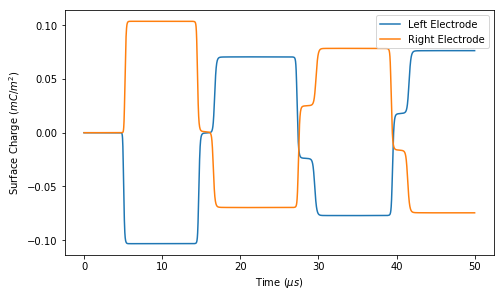

In [16]:
nns=int(numberOfSteps/stepping)
print(nns)
storeCurrent.shape
plt.figure(figsize=(7.7,4.5))
plt.plot(np.arange(nns)/100,(storenetcharge[:,nwd1]*dx*10e3),label='Left Electrode')
plt.plot(np.arange(nns)/100,(storenetcharge[:,nwd1+ngrid0+1])*dx*10e3,label='Right Electrode')
plt.xlabel('Time $(\mu s)$')
plt.ylabel('Surface Charge $(mC/m^2$)')
plt.legend()
plt.savefig('Charge Accumulation.jpg', format='jpg', dpi=1000)
print(dx)

# Temporal Variation of electron number density

C:\Users\Saurav\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


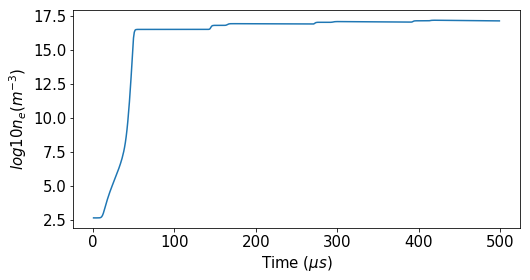

In [17]:
from matplotlib import rcParams
plt.figure(figsize=(8,4))
rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 15})
jodekoelectron=np.zeros(int(numberOfSteps/(10*stepping)),float)
for jodne in np.arange(int(numberOfSteps/(10*stepping))):
    jodekoelectron[jodne]=np.sum(storedensity[10*jodne,0,:])
plt.plot(np.log10(jodekoelectron[:]/(ngrid0+2)))
plt.xlabel("Time $(\mu s)$")
plt.ylabel("$log10 n_e (m^{-3})$")
#plt.axis([700,900,40,50])
plt.savefig('logelectrondensity1d.jpg', format='jpg', dpi=1000)